In [168]:
import skimage
import matplotlib.pyplot as plt
from pathlib import Path
from os import walk
import numpy as np
from pytesseract import image_to_string
from imutils import resize

In [169]:
LABELLED = Path('Dataset/Labelled')
UNLABELLED = Path('Dataset/Raw')

def get_label(file_name: str) -> tuple[int, int, int, int, int]:
    tokens = file_name.split('_')
    digit = tokens[0]
    sum = tokens[1]
    borders = tokens[2]
    top, bottom, left, right = borders
    return (digit, sum, top, bottom, left, right)

def fetch_images(SOURCE: Path, labelled: bool = True):
    for root, dirs, files in walk(SOURCE):
        print(root, dirs, files)
        for file in files:
            file_path = Path(root)/file
            image = skimage.io.imread(file_path)
            gray = skimage.color.rgb2gray(image)
            label = file
            if labelled:
                label = get_label(file)
            yield (gray, label)
        

def image_show(image: np.ndarray, *args, **kwargs) -> None:
    plt.imshow(image, *args, **kwargs)
    plt.xticks([])
    plt.yticks([])

def ocr(image: np.ndarray, w, h, xmin, xmax, ymin, ymax, offset_min, offset_max) -> int:
    image = image[ymin - 5:ymax + 5, xmin - 5:xmax + 5].astype(np.uint8)
    detected = image_to_string(image, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789').replace('\n', '')
    if detected != '':
        return detected[0]
    return ''

Dataset\Labelled [] ['0_0_0111_00161.png', '0_0_1101_00002.png', '0_0_1110_00159.png', '0_11_1110_00156.png', '0_6_1111_00150.png', '0_8_1011_00151.png', '0_9_1110_00000.png', '1_0_0111_00158.png', '3_0_0011_00152.png', '3_0_1100_00001.png', '4_0_1101_00154.png', '5_0_0101_00160.png', '6_0_0110_00153.png', '8_0_1101_00157.png', '9_0_0011_00149.png', '9_0_0111_00155.png']


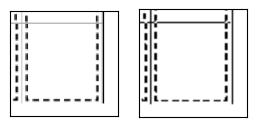

dict_values(['0', 0, False, False, False, False]) 0_0_0111_00161.png


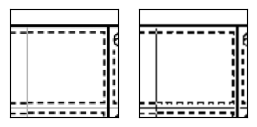

dict_values(['0', 0, False, False, False, False]) 0_0_1101_00002.png


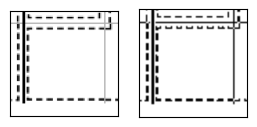

dict_values(['0', 0, False, False, False, False]) 0_0_1110_00159.png


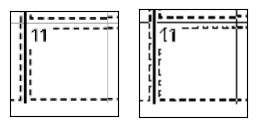

dict_values(['0', 0, False, False, False, False]) 0_11_1110_00156.png


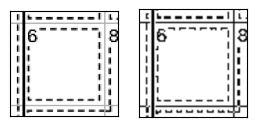

dict_values(['0', 0, False, False, False, False]) 0_6_1111_00150.png


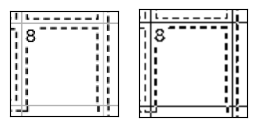

dict_values(['0', 0, False, False, False, False]) 0_8_1011_00151.png


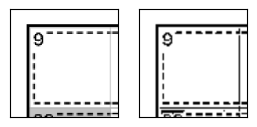

dict_values(['0', 0, False, False, False, False]) 0_9_1110_00000.png


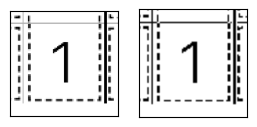

dict_values(['0', 0, False, False, False, False]) 1_0_0111_00158.png


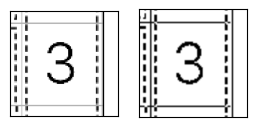

dict_values(['0', 0, False, False, False, False]) 3_0_0011_00152.png


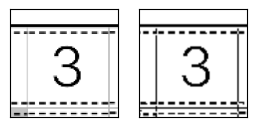

dict_values(['0', 0, False, False, False, False]) 3_0_1100_00001.png


In [183]:
i = 0
for image, label in fetch_images(LABELLED, False):
    output = {'digit': '0', 'sum': 0, 'top_border': False, 'bottom_border': False, 'left_border': False, 'right_border': False}
    threshold = skimage.filters.threshold_local(image)
    mask = (image >= threshold).astype(np.uint8)
    mask = skimage.transform.resize(mask, (256, 256))
    h, w = image.shape

    plt.subplot(1,4,1)
    image_show(image, cmap='gray')
    plt.subplot(1,4, 2)
    image_show(mask, cmap='gray')

    labelled_image = skimage.measure.label(mask)
    
    roi = skimage.measure.regionprops(labelled_image)
    roi.sort(key=lambda x: (x.bbox[1], x.bbox[0]))
    for region in roi:
        ymin, xmin, ymax, xmax = region.bbox
        area = region.num_pixels
        width, height = xmax - xmin, ymax - ymin
        if ymin <= h // 2 <= ymax and xmin <= w // 2 <= xmax and width < w // 2 and area > 100:
            # bounding box about center
            # feed regions[region.slice] into OCR
            #plt.subplot(1,4,4)
            #plt.imshow(mask[ymin:ymax, xmin:xmax].astype(np.uint8), cmap='gray')
            #plt.subplot(1,4,2)
            
            output_1 = '1' # ocr(mask, w, h, xmin, xmax, ymin, ymax, 5, 10)
            output['digit'] = output_1 if output_1 != '' else '0'
        elif width / height > 1.5 and width < w // 2 and w // 4 < xmin <= xmax < 3 * w // 4: # horizontal dotted line
            if ymin < h // 2: # top border
                output['top_border'] = True
            else:
                output['bottom_border'] = True
        elif height / width > 1.5 and height < h // 2 and h // 4 < ymin <= ymax < 3 * h // 4: # vertical dotted line
            if xmin < w // 2: # left border
                output['left_border'] = True
            else:
                output['right_border'] = True
        elif xmax < w // 2 and ymax < h // 2 and area > 10 and 1/2 < height / width < 3: # top left corner
            
            #plt.subplot(1,4,3)
            #plt.imshow(mask[ymin - 2:ymax + 2, xmin - 2:xmax + 2].astype(np.uint8), cmap='gray')
            #plt.subplot(1,4,2)
            
            output_1 = '1' # ocr(mask, w, h, xmin, xmax, ymin, ymax, 2, 4)
            if output_1 != '':
                output['sum'] *= 10
                output['sum'] += int(output_1) # OCR-ed value

        rect = plt.Rectangle((xmin, ymin), width, height, edgecolor='red', fill=False)
        plt.gca().add_patch(rect)

    plt.show()
    print(output.values(), label)
    i += 1
    if i >= 10:
        break